In [1]:
# Estos dos comandos evitan que haya que hacer reload cada vez que se modifica un paquete
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from problema_1 import plot_bar_chart
# Importo el paquete para graficar
from matplotlib import pyplot as plt

# Naive bayes - Clasificación

### Bibliografía recomendada
https://nlp.stanford.edu/IR-book/ - Capitulo 13 -  
http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes

## Ejemplos

![](./images/student-admission.png)

![](./images/chip-test.png)

## Introducción teórica

### Teorema de Bayes
$P(y|x_1,x_2,...,x_n) = \large \frac{P(x_1, x_2,...,x_n|y) P(y)}{P(x_1,x_2,...,x_n)}$

El numerador:

$ \large P(x_1, x_2,...,x_n|y) P(y) = P(y, x_1, x_2,...,x_n)$

Por la regla de la cadena:

$P(x_1,x_2, x_3, y) = P(x_1 | x_2, x_3,y)P(x_2,x_3, y) = P(x_1 | x_2, x_3,y)P(x_2|x_3, y)P(x_3, y) = P(x_1 | x_2, x_3,y)P(x_2|x_3, y)P(x_3| y)P(y)$

$P(x_1,x_2, x_3, y) = P(x_1 | x_2, x_3,y)P(x_2|x_3, y)P(x_3| y)P(y)$

#### Ejemplo con Aplicación SPAM

$P(comprar,oferta,ganaste,SPAM) = P(comprar | oferta, ganaste,SPAM)P(oferta|ganaste, SPAM)P(ganaste| SPAM)P(SPAM)$

Asumiendo independencia

$P(x_i|y) = P(x_i|y,x_1,...)$

$P(comprar,oferta,ganaste,SPAM) = P(comprar | SPAM)P(oferta|SPAM)P(ganaste| SPAM)P(SPAM)$

### Naive Bayes

$P(y|x_1,x_2,...,x_n) = \large \frac{P(y)\prod P(x_i/y)} {P(x_1,x_2,...,x_n)} = \alpha {P(y)\prod P(x_i/y)}$

(Compararlo con teorema de Bayes)

$\large \hat{y} = arg max_y [{P(y)\prod P(x_i/y)}]$

Ejemplo SPAM: 

La variable aleatoria $y$ puede ser: [SPAM, NO_SPAM]. Calculo ${P(y)\prod P(x_i/y)}$ para ambos casos y me quedo con el mayor

Como el denominador es el mismo para ambos casos, no hace falta calcularlo

## Detección de SPAM
V. Metsis, I. Androutsopoulos and G. Paliouras (2006). Spam filtering with Naive Bayes – Which Naive Bayes? 3rd Conf. on Email and Anti-Spam (CEAS).
http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=1EEA3C5EE5DDF8409BCC0F09BFB7D98B?doi=10.1.1.61.5542&rep=rep1&type=pdf

Tenemos un dataset donde ya esta preprocesado el texto
- Lemmatization, stemming
- Stop words

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
#CountVectorize -> Dado un conjunto de archivos, me devuelve una matriz con la cantidad de veces que aparece 
#... cada una de las palabras posibles, en cada archivo

In [4]:
import os
from collections import Counter
train_dir = './ling-spam/train-mails'
emails = [os.path.join(train_dir,f) for f in os.listdir(train_dir)] 

In [5]:
emails[0:10]

['./ling-spam/train-mails/6-338msg1.txt',
 './ling-spam/train-mails/5-1300msg3.txt',
 './ling-spam/train-mails/6-250msg1.txt',
 './ling-spam/train-mails/6-266msg3.txt',
 './ling-spam/train-mails/spmsgc10.txt',
 './ling-spam/train-mails/5-1326msg1.txt',
 './ling-spam/train-mails/spmsga114.txt',
 './ling-spam/train-mails/spmsga100.txt',
 './ling-spam/train-mails/6-110msg3.txt',
 './ling-spam/train-mails/6-126msg1.txt']

In [6]:
with open(emails[1]) as m:
    print(m)
    for i,line in enumerate(m):
        print(i, line)

<_io.TextIOWrapper name='./ling-spam/train-mails/5-1300msg3.txt' mode='r' encoding='UTF-8'>
0 Subject: conf : salsa iii

1 

2 greeting salsa organize committee ! ! here await call paper salsa iii . please forward message those interest , post notice department . forward y ' april ! * * * * * * * * * * * * * * * * * * * * * * * * * s l s * * * * * * * * * * * * * * * * * * * * * * * * * call papers symposium language society - austin please announce first annual meet hold april 7 - 9 , 1995 university texa austin . abstract invite topic concern relationship between language , culture society . include limit : linguistic anthropology variation social network natural discourse ethnography communication speech play , verbal art , poetic discourse - base approach language culture * * * * * * * * * * * * * * * * * * * * * * * * 1995 keynote speakers * * * * * * * * * * * * * * * * * * * * * * * * michael silverstein university chicago keith walter university texa austin paper deliver confer

In [7]:
def make_Dictionary(train_dir):
    # Train dir es la carpeta para parsear
    emails_array = []
    labels = []
    # Emails es una lista con los nombres de los archivos
    emails = [os.path.join(train_dir,f) for f in os.listdir(train_dir)] 
    # All words contendrá todas las palabras del mail
    all_words = []       
    for mail in emails:
        # mail es el nombre del archivo
        with open(mail) as m:
            # m es el archivo abierto
            if 'spmsg' in mail.split('/')[-1]:
                # Si el nombre del archivo contiene 'spmsg' es spam
                labels.append(True)
            else:
                labels.append(False)
            # email_str va a guardar el mail como string
            email_str = ''
            for i,line in enumerate(m):
                if i == 2:  #Body of email is only 3rd line of text file
                    words = line.split()
                    all_words += words
                    email_str = email_str + ' ' + line
            emails_array.append(email_str)
    dictionary = Counter(all_words)
    return dictionary, emails_array, labels

def remove_uncommon_words(dictionary):
    # Dictionary es un counter
    dict_copy = { k : v for k,v in dictionary.items()}
    list_to_remove = dictionary.keys()
    for item in list_to_remove:
        if item.isalpha() == False: 
            # Remueve lo que no sean palabras con letras del abcedario
            del dict_copy[item]
        elif len(item) == 1:
            # Remueve las palabras de una letra
            del dict_copy[item]
    return Counter(dict_copy)

In [8]:
def read_emails_and_get_dict(folder, max_features=3000):
    dictionary, emails_array, labels = make_Dictionary(folder)
    dictionary = remove_uncommon_words(dictionary)
    dictionary = dictionary.most_common(max_features)
    vocabulary = [key[0] for key in dictionary]
    return vocabulary, emails_array, np.array(labels)

In [9]:
max_features = 3000

In [10]:
vocabulary, emails_array, labels = read_emails_and_get_dict('./ling-spam/train-mails', max_features)
count_vectorizer = CountVectorizer(vocabulary=vocabulary)
feature_matrix = count_vectorizer.fit_transform(emails_array)

In [11]:
print(labels[0:19])
print(vocabulary[0:25])
print(feature_matrix)

[False False False False  True False  True  True False False  True False
  True False False  True  True  True False]
['order', 'address', 'report', 'mail', 'send', 'language', 'email', 'program', 'our', 'list', 'one', 'name', 'receive', 'money', 'free', 'work', 'information', 'business', 'please', 'university', 'us', 'day', 'follow', 'internet', 'over']
  (0, 19)	1
  (0, 24)	2
  (0, 273)	1
  (0, 305)	1
  (0, 533)	1
  (0, 562)	1
  (0, 701)	1
  (0, 717)	1
  (0, 1285)	1
  (0, 1418)	1
  (0, 1650)	2
  (1, 1)	2
  (1, 4)	3
  (1, 5)	3
  (1, 6)	2
  (1, 11)	1
  (1, 12)	2
  (1, 16)	1
  (1, 18)	3
  (1, 19)	3
  (1, 22)	1
  (1, 27)	2
  (1, 29)	3
  (1, 31)	3
  (1, 32)	1
  :	:
  (701, 748)	1
  (701, 800)	1
  (701, 865)	1
  (701, 873)	1
  (701, 913)	1
  (701, 919)	1
  (701, 952)	1
  (701, 1017)	1
  (701, 1150)	1
  (701, 1232)	1
  (701, 1263)	1
  (701, 1355)	1
  (701, 1485)	1
  (701, 1486)	1
  (701, 1603)	1
  (701, 1637)	1
  (701, 1816)	1
  (701, 1825)	1
  (701, 1903)	1
  (701, 2362)	1
  (701, 2402)	1
 

In [12]:
print(feature_matrix.sum(axis=0).shape)
print(feature_matrix.sum(axis=0))
# Le suma 1, para evitar que haya un mail que de 0 (que no tenga ninguna de las palabras del set), y el producto de 0
print(feature_matrix.sum(axis=0) + 1)
print((feature_matrix.sum(axis=0) + 1).sum())

(1, 3000)
[[1423 1302 1216 ...    8    8    8]]
[[1424 1303 1217 ...    9    9    9]]
157987


In [13]:
def get_histogram_from_matrix(alpha, feature_matrix):
    # Alpha es para suavizar y evitar la probabilidad cero. Normalmente 1
    # Es como agregar un mail con todas las palabras
    words_distribution_un = feature_matrix.sum(axis=0) + alpha
    words_distribution = words_distribution_un/(words_distribution_un.sum()) # + alpha*feature_matrix.shape[1])
    return words_distribution

spam_feature_matrix = feature_matrix[labels,:]
ham_feature_matrix = feature_matrix[np.logical_not(labels),:]

print('SPAM:',labels.nonzero()[0].shape[0],
      'HAM:',np.logical_not(labels).nonzero()[0].shape[0],
      'total:',len(labels))

print()
print('Palabras diferentes')
print('SPAM:', spam_feature_matrix.nonzero()[0].shape[0],
      'HAM:',ham_feature_matrix.nonzero()[0].shape[0])

print()
print('Cantidad de palabras')
print('SPAM:',spam_feature_matrix.sum(), 'HAM:',ham_feature_matrix.sum())


# P(x_i/SPAM)
spam_words_distribution = get_histogram_from_matrix(0.1, spam_feature_matrix)
# P(x_i/HAM)
ham_words_distribution = get_histogram_from_matrix(0.1, ham_feature_matrix)

SPAM: 351 HAM: 351 total: 702

Palabras diferentes
SPAM: 49290 HAM: 33347

Cantidad de palabras
SPAM: 98144 HAM: 56843


$\hat{y} = arg max_y [{P(y)\prod P(x_i/y)}]$

$y = [SPAM, HAM]$

In [14]:
def plot_bar_chart(P, vocabulary = None, title='title'):
    N = len(P)
    plt.figure(figsize=(20, 5)) # Tamaño del gráfico
    indexes = list(range(1, len(P) + 1))
    plt.bar(indexes, P, width=0.75, color='b') # Grafico
    plt.title(title)

    # Definición de indices
    if not vocabulary:
        string_indexes = [str(i) for i in indexes]
    else:
        string_indexes = [vocabulary[i-1] for i in indexes]
    plt.xlim([0,N+1])
    plt.xticks(indexes, string_indexes) 
    plt.xticks(rotation=60)
    plt.show()

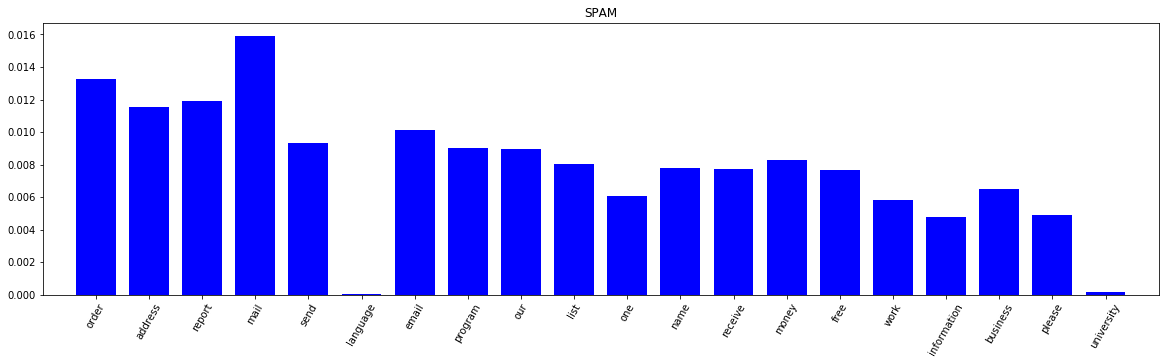

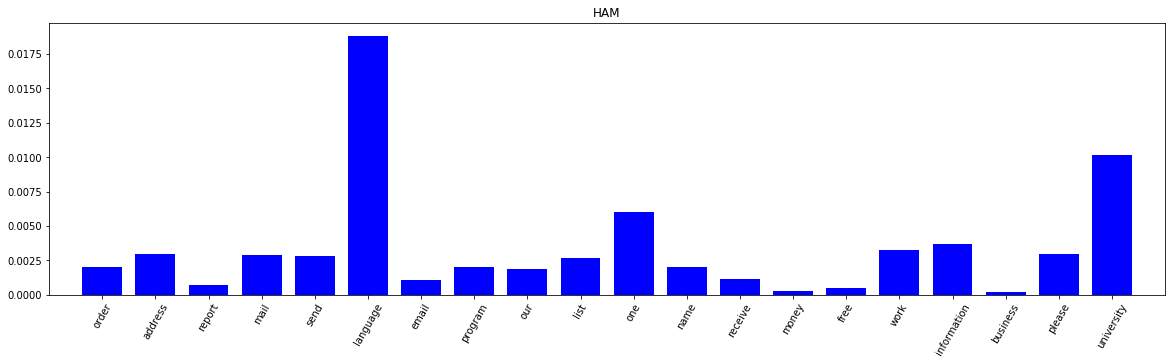

In [15]:
N = 20
plot_bar_chart(np.array(spam_words_distribution)[0][:N],
               vocabulary = vocabulary,
               title='SPAM')
plot_bar_chart(np.array(ham_words_distribution)[0][:N],
               vocabulary = vocabulary,
               title='HAM')

In [16]:
# Veamos si el primer email es SPAM o no
# El primer mail corresponde a la primer fila de la matriz
row = feature_matrix[0,:]
print('Primer email codificado:')
print(row)
non_zero_row = row.nonzero()
print('Elementos distintos de cero:',non_zero_row[1])
print('Producto, no es necesario [P(Y) = P(SPAM) = P(HAM)] por que es para ambos casos igual. Lo mismo el denominador')
print(np.power(spam_words_distribution[non_zero_row], feature_matrix[non_zero_row]).prod())
print(np.power(ham_words_distribution[non_zero_row], feature_matrix[non_zero_row]).prod())

#Aplicamos Log para que no tienda a 0 (para determinar cual es mas grande, es lo mismo)
print('Log likelihood')
print(np.log(spam_words_distribution[non_zero_row])*feature_matrix[non_zero_row])
print(np.log(ham_words_distribution[non_zero_row])*feature_matrix[non_zero_row])

Primer email codificado:
  (0, 19)	1
  (0, 24)	2
  (0, 273)	1
  (0, 305)	1
  (0, 533)	1
  (0, 562)	1
  (0, 701)	1
  (0, 717)	1
  (0, 1285)	1
  (0, 1418)	1
  (0, 1650)	2
Elementos distintos de cero: [  19   24  273  305  533  562  701  717 1285 1418 1650]
Producto, no es necesario [P(Y) = P(SPAM) = P(HAM)] por que es para ambos casos igual. Lo mismo el denominador
3.259829637980896e-47
1.8934243821672183e-43
Log likelihood


ValueError: shapes (1,11) and (1,11) not aligned: 11 (dim 1) != 1 (dim 0)

¿Por que usamos log likelihood?

In [ ]:
def get_accuracy(feature_matrix, labels, spam_words_distribution, ham_words_distribution):
    P_SPAM = labels.nonzero()[0].shape[0]/len(labels) # Por que no es necesario en este caso?
    P_HAM = np.logical_not(labels).nonzero()[0].shape[0]/len(labels) # Por que no es necesario en este caso?
    correct_count = 0
    for i, row in enumerate(feature_matrix):
        coded_email = row.nonzero()
        spam_prod = np.log(spam_words_distribution[coded_email]) * feature_matrix[i][coded_email].T
        ham_prod = np.log(ham_words_distribution[coded_email]) * feature_matrix[i][coded_email].T
        spam_log_likelihood = spam_prod+ np.log(P_SPAM)
        ham_log_likelihood = ham_prod + np.log(P_HAM)
        SPAM = spam_log_likelihood>=ham_log_likelihood
        if SPAM == labels[i]:
            correct_count = correct_count + 1
    print('%0.3f'%(correct_count/len(labels)))

In [ ]:
get_accuracy(feature_matrix, labels, spam_words_distribution, ham_words_distribution)

## Test set

In [17]:
_, emails_array, labels_test = read_emails_and_get_dict('./ling-spam/test-mails', max_features)
count_vectorizer_test = CountVectorizer(vocabulary=vocabulary)
feature_matrix_test = count_vectorizer.fit_transform(emails_array)

In [18]:
get_accuracy(feature_matrix_test, labels_test, spam_words_distribution, ham_words_distribution)

NameError: name 'get_accuracy' is not defined

# Sklearn MultinomialNB

In [19]:
from sklearn.naive_bayes import MultinomialNB
#Multinomial, tiene en cuenta si las palabras aparecen varias veces

In [20]:
clf = MultinomialNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=False)

In [21]:
print(feature_matrix)
print(labels)
clf.fit(feature_matrix, labels)

  (0, 19)	1
  (0, 24)	2
  (0, 273)	1
  (0, 305)	1
  (0, 533)	1
  (0, 562)	1
  (0, 701)	1
  (0, 717)	1
  (0, 1285)	1
  (0, 1418)	1
  (0, 1650)	2
  (1, 1)	2
  (1, 4)	3
  (1, 5)	3
  (1, 6)	2
  (1, 11)	1
  (1, 12)	2
  (1, 16)	1
  (1, 18)	3
  (1, 19)	3
  (1, 22)	1
  (1, 27)	2
  (1, 29)	3
  (1, 31)	3
  (1, 32)	1
  :	:
  (701, 748)	1
  (701, 800)	1
  (701, 865)	1
  (701, 873)	1
  (701, 913)	1
  (701, 919)	1
  (701, 952)	1
  (701, 1017)	1
  (701, 1150)	1
  (701, 1232)	1
  (701, 1263)	1
  (701, 1355)	1
  (701, 1485)	1
  (701, 1486)	1
  (701, 1603)	1
  (701, 1637)	1
  (701, 1816)	1
  (701, 1825)	1
  (701, 1903)	1
  (701, 2362)	1
  (701, 2402)	1
  (701, 2495)	1
  (701, 2672)	2
  (701, 2777)	1
  (701, 2986)	1
[False False False False  True False  True  True False False  True False
  True False False  True  True  True False False  True False  True  True
  True False  True False False False False False  True False  True False
 False  True  True False  True  True  True False False  True False False
 

MultinomialNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=False)

In [22]:
clf.score(feature_matrix, labels)

0.99002849002849

In [23]:
clf.score(feature_matrix_test, labels_test)

0.9615384615384616

In [24]:
#Le paso un mail y me dice si es SPAM o NO
clf.predict(feature_matrix_test[100])

array([False])

In [25]:
#Me devuelve las probabilidades
clf.predict_proba(feature_matrix_test[100:110])

array([[1.00000000e+000, 4.32577416e-203],
       [1.00000000e+000, 9.25701855e-168],
       [4.22016090e-015, 1.00000000e+000],
       [1.00000000e+000, 9.54021707e-106],
       [9.61964302e-147, 1.00000000e+000],
       [2.47312152e-090, 1.00000000e+000],
       [9.85266748e-006, 9.99990147e-001],
       [9.76629082e-029, 1.00000000e+000],
       [1.00000000e+000, 2.04412793e-077],
       [1.00000000e+000, 7.70903147e-057]])

# Sklearn BernoulliNB
Suele ser interesante evaluar Multinomial y Bernoulli para comparar resultados. A veces para textos cortos BernoulliNB puede dar mejores resultados

In [26]:
from sklearn.naive_bayes import BernoulliNB

In [27]:
#Si es mayor a binarize, lo toma como 1 (como que aparece). Si es menor lo toma como 0 (como que no aparece).
#Este modelo solo toma en cuenta si aparece la palabra o no. No tiene en cuenta la cantidad
clf_Ber = BernoulliNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=False, binarize=0.5)

In [28]:
clf_Ber.fit(feature_matrix, labels)

BernoulliNB(alpha=1, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

In [29]:
clf_Ber.score(feature_matrix, labels)

0.8603988603988604

In [30]:
clf_Ber.score(feature_matrix_test, labels_test)

0.7653846153846153

# ¿Es posible graficar un problema de dimensión 3000 en 2 dimensiones?

In [31]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
fmd = feature_matrix.todense()
svd = TruncatedSVD(n_components=8, n_iter=200, random_state=42)
svd.fit(fmd.T)
X_embedded = TSNE(n_components=2).fit_transform(svd.components_.T)

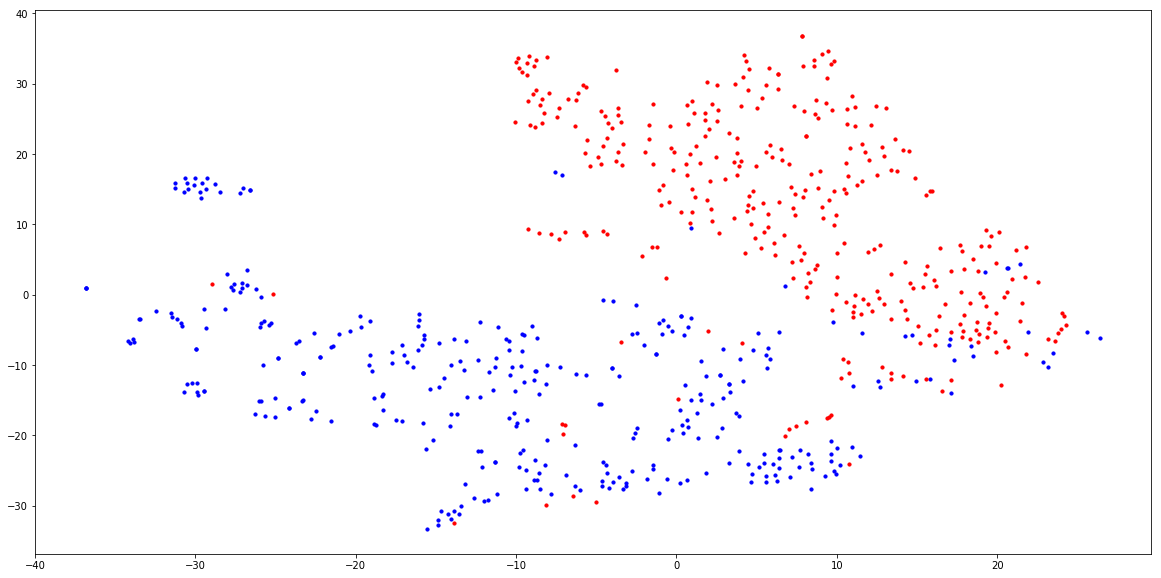

In [32]:
plt.figure(figsize=(20,10))
plt.scatter(X_embedded[labels,0], X_embedded[labels,1], color='b', s=10)
plt.scatter(X_embedded[np.logical_not(labels),0], X_embedded[np.logical_not(labels),1], color='r', s=10)
plt.show()

# Gaussian Naive Bayes
https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Sex_classification

#Para datos dependientes no es muy bueno Naive Bayes (En este caso son datos dependientes)

In [33]:
# Datos originales de wikipedia
data = [
    {"genero":'hombre', 'altura': 6, 'peso': 180,'pie':12}, 
    {"genero":'hombre', 'altura': 5.92, 'peso': 190,'pie':11}, 
    {"genero":'hombre', 'altura': 5.58, 'peso': 170,'pie':12}, 
    {"genero":'hombre', 'altura': 5.92, 'peso': 165,'pie':10}, 
    {"genero":'mujer', 'altura': 5, 'peso': 100,'pie':6}, 
    {"genero":'mujer', 'altura': 5.5, 'peso': 150,'pie':8}, 
    {"genero":'mujer', 'altura': 5.42, 'peso': 130,'pie':7}, 
    {"genero":'mujer', 'altura': 5.75, 'peso': 150,'pie':9}, 
]

In [34]:
# Altura en cm y peso en kg
data = [{'altura': 183, 'genero': 'hombre', 'peso': 82, 'pie': 12},
         {'altura': 180, 'genero': 'hombre', 'peso': 86, 'pie': 11},
         {'altura': 170,'genero': 'hombre','peso': 77,'pie': 12},
         {'altura': 180, 'genero': 'hombre', 'peso': 75, 'pie': 10},
         {'altura': 152, 'genero': 'mujer', 'peso': 45, 'pie': 6},
         {'altura': 167, 'genero': 'mujer', 'peso': 68, 'pie': 8},
         {'altura': 165, 'genero': 'mujer', 'peso': 59, 'pie': 7},
         {'altura': 175, 'genero': 'mujer', 'peso': 68, 'pie': 9}]

In [35]:
GNB_features_matrix = np.zeros((len(data),3))
GNB_labels = np.empty((len(data)), dtype=object)
print('Matriz y lista antes de llenar')
print(GNB_features_matrix)
print(GNB_labels)

for i, person in enumerate(data):
    GNB_features_matrix[i, 0] = person['altura']
    GNB_features_matrix[i, 1] = person['peso']
    GNB_features_matrix[i, 2] = person['pie']
    GNB_labels[i] = person['genero']
print()
print('Matriz y lista con los datos:')
print(GNB_features_matrix)
print(GNB_labels)

Matriz y lista antes de llenar
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[None None None None None None None None]

Matriz y lista con los datos:
[[183.  82.  12.]
 [180.  86.  11.]
 [170.  77.  12.]
 [180.  75.  10.]
 [152.  45.   6.]
 [167.  68.   8.]
 [165.  59.   7.]
 [175.  68.   9.]]
['hombre' 'hombre' 'hombre' 'hombre' 'mujer' 'mujer' 'mujer' 'mujer']


In [36]:
men_means = GNB_features_matrix[GNB_labels=='hombre',:].mean(axis=0)
women_means = GNB_features_matrix[GNB_labels=='mujer',:].mean(axis=0)
men_vars = GNB_features_matrix[GNB_labels=='hombre',:].var(axis=0, ddof=1)
women_vars = GNB_features_matrix[GNB_labels=='mujer',:].var(axis=0, ddof=1)
print('medias de los hombres:', men_means)
print('varianzas de los hombres:', men_vars)
print('medias de las mujeres:', women_means)
print('varianzas de las mujeres:', women_vars)

medias de los hombres: [178.25  80.    11.25]
varianzas de los hombres: [32.25       24.66666667  0.91666667]
medias de las mujeres: [164.75  60.     7.5 ]
varianzas de las mujeres: [ 90.91666667 118.           1.66666667]


In [37]:
def gaussian(x, mu, sig):
    return np.exp(-np.power((x - mu)/sig, 2.)/2)/(np.sqrt(2.*np.pi)*sig)

def plot_gaussian(mu=0, sig= 1, points = 200, N = 2, marker=None, label = None, x = None, color = None, 
                  x_label='',y_label='',ax = None, figsize = (20,10), center_label_tick = None):
    if ax is None:
        f, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize = figsize)
    if x is None:
        x = np.linspace(mu-N*sig, mu+N*sig, points)
    y = gaussian(x, mu, sig)
    ax.plot(x,y, marker = marker, label = label, color = color)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)

    if center_label_tick is not None:
        labels = [item.get_text() for item in ax.get_xticklabels()]
        labels[int((len(labels)-1)/2)] = center_label_tick
        ax.set_xticklabels(labels)

    return x, y

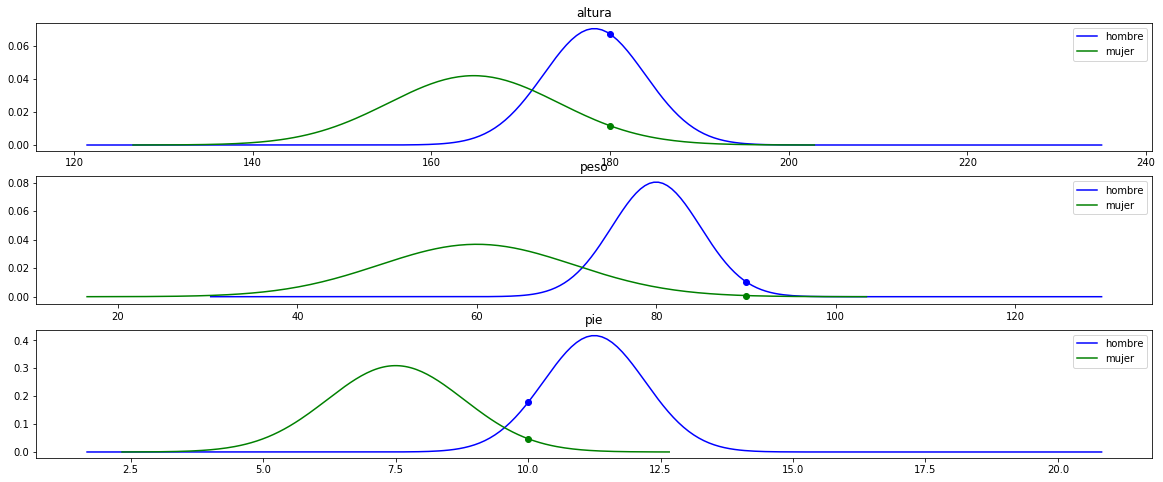

In [38]:
sample = np.array([180,90,10])

f, axs = plt.subplots(3, 1, sharey=False, sharex=False, figsize = (20,8))
keys = ['altura', 'peso','pie']
for i, ax in enumerate(axs):
    plot_gaussian(men_means[i], np.sqrt(men_vars[i]), ax=ax, N=10, color='b', label='hombre')
    plot_gaussian(women_means[i], np.sqrt(women_vars[i]), ax=ax, N=4, color='g', label='mujer')
    ax.scatter(sample[i], gaussian(sample[i], men_means[i], np.sqrt(men_vars[i])), color='b')
    ax.scatter(sample[i], gaussian(sample[i], women_means[i], np.sqrt(women_vars[i])), color='g')
    ax.title.set_text(keys[i])
    ax.legend()
plt.show()

In [39]:
p_hombre = len(GNB_features_matrix[GNB_labels=='hombre',:])/len(GNB_features_matrix)
p_altura_hombre = gaussian(sample[0], men_means[0], np.sqrt(men_vars[0]))
p_peso_hombre = gaussian(sample[1], men_means[1], np.sqrt(men_vars[1]))
p_pie_hombre = gaussian(sample[2], men_means[2], np.sqrt(men_vars[2]))
posterior_hombre = p_hombre*p_altura_hombre*p_peso_hombre*p_pie_hombre
print('Posteriori de hombre:', posterior_hombre)

Posteriori de hombre: 6.297813911136489e-05


In [40]:
p_mujer = len(GNB_features_matrix[GNB_labels=='hombre',:])/len(GNB_features_matrix)
p_altura_mujer = gaussian(sample[0], women_means[0], np.sqrt(women_vars[0]))
p_peso_mujer = gaussian(sample[1], women_means[1], np.sqrt(women_vars[1]))
p_pie_mujer = gaussian(sample[2], women_means[2], np.sqrt(women_vars[2]))
posterior_mujer = p_mujer*p_altura_mujer*p_peso_mujer*p_pie_mujer
print('Posteriori de Mujer:', posterior_mujer)

Posteriori de Mujer: 2.2363824637982252e-07


In [41]:
if posterior_mujer>posterior_hombre:
    print('MUJER')
else:
    print('HOMBRE')

HOMBRE


Notar que no hace falta calcular el denominador

# Utilizando sklearn

In [44]:
#Asumo que los datos tienen una distribucion Gaussiana
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(GNB_features_matrix, GNB_labels)

[[183.  82.  12.]
 [180.  86.  11.]
 [170.  77.  12.]
 [180.  75.  10.]
 [152.  45.   6.]
 [167.  68.   8.]
 [165.  59.   7.]
 [175.  68.   9.]]
['hombre' 'hombre' 'hombre' 'hombre' 'mujer' 'mujer' 'mujer' 'mujer']


In [43]:
samples = np.array([[180,90,10], [160, 70, 8], [178, 73, 9], [178, 74, 9]])
print(y_pred.predict(samples))
print(y_pred.predict_proba(samples))

['hombre' 'mujer' 'mujer' 'hombre']
[[9.99077440e-01 9.22560042e-04]
 [3.59206251e-07 9.99999641e-01]
 [4.34003950e-01 5.65996050e-01]
 [5.59309521e-01 4.40690479e-01]]


## Problema 2
Utilizando las siguientes funciones/paquetes resolver los siguientes problemas de clasificación en **problema_2.py**:

**genfromtxt** de **numpy** para leer los dos datasets:
- ./datasets/student_admission.txt
- ./datasets/chip_tests.txt

**train_test_split** de **sklearn** para dividir entre test set y train set. Recomendamos un 40% de datos para test set

**GaussianNB** de **sklearn** como modelo de ML.

Y la función **plot_boundaries(X_train, X_test, y_train, y_test, score, predict_proba, ax=ax, h=h)** incluida en problema_2.py para graficar los resultados. X_train es un np.array con los features de entrada, y_train es la etiqueta. Lo mismo con X_test e y_test, Score es el 'accuracy' del modelo, predict_proba es la función que dada una entrada de la probabilidad de clasificar correcto y h es el paso para la grafica del 'boundary'